In [1]:
# ---
# 04_predictive_models.ipynb
# Predicting running outcomes with ML
# ---

import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score,
    accuracy_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [2]:
# -----------------------------
# 1. Load Enriched Dataset
# -----------------------------
data_path = Path("../data/processed/runs_summary_features.csv")
summary_df = pd.read_csv(data_path, parse_dates=["date"])   # <-- renamed here

print("Shape:", summary_df.shape)
summary_df.head()



Shape: (826, 17)


,run_id,date,total_distance_km,duration_min,avg_pace_min_km,min_pace_min_km,fastest_1km_pace,fastest_5min_pace,avg_cadence,total_elev_gain,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift,week,load_7d,load_28d
0,223706316,2014-09-29,13.41515,76.366667,NaN,NaN,NaN,NaN,NaN,1611.2,NaN,NaN,NaN,NaN,2014-09-29,13.41515,13.41515
1,224118153,2014-09-30,2.66860,9.350000,NaN,NaN,NaN,NaN,NaN,200.8,NaN,NaN,NaN,NaN,2014-09-29,16.08375,16.08375
2,224118406,2014-09-30,1.47677,7.100000,NaN,NaN,NaN,NaN,NaN,121.6,NaN,NaN,NaN,NaN,2014-09-29,17.56052,17.56052
3,224118046,2014-09-30,2.76147,9.350000,NaN,NaN,NaN,NaN,NaN,109.0,NaN,NaN,NaN,NaN,2014-09-29,20.32199,20.32199
4,224117880,2014-09-30,4.35972,19.000000,NaN,NaN,NaN,NaN,NaN,408.6,NaN,NaN,NaN,NaN,2014-09-29,24.68171,24.68171


In [3]:
print("Columns in summary_df:")
print(summary_df.columns.tolist())


Columns in summary_df:
['run_id', 'date', 'total_distance_km', 'duration_min', 'avg_pace_min_km', 'min_pace_min_km', 'fastest_1km_pace', 'fastest_5min_pace', 'avg_cadence', 'total_elev_gain', 'avg_stride_len_m', 'avg_gct_est_ms', 'pace_variability', 'cadence_drift', 'week', 'load_7d', 'load_28d']


In [4]:
# -----------------------------
# 1.1 Feature Engineering — Derived Metrics
# -----------------------------
# Adds rolling loads, stride length, variability, and fastest-segment features.
# Automatically skips already existing columns.
# -----------------------------

# Use the correct distance column
distance_col = "total_distance_km" if "total_distance_km" in summary_df.columns else "distance_km"

# --- Rolling training load features ---
if "load_7d" not in summary_df.columns or "load_28d" not in summary_df.columns:
    summary_df = summary_df.sort_values("date")
    summary_df["load"] = summary_df["duration_min"] * (1 / summary_df["avg_pace_min_km"].clip(lower=0.1))
    summary_df["load_7d"] = summary_df["load"].rolling(window=7, min_periods=1).mean()
    summary_df["load_28d"] = summary_df["load"].rolling(window=28, min_periods=1).mean()

# --- Biomechanical approximations ---
if "avg_stride_len_m" not in summary_df.columns:
    summary_df["avg_stride_len_m"] = (summary_df[distance_col] * 1000) / (
        summary_df["avg_cadence"] * summary_df["duration_min"] * (1/60)
    )
    summary_df["avg_stride_len_m"] = summary_df["avg_stride_len_m"].clip(0, 2.5)

if "avg_gct_est_ms" not in summary_df.columns:
    summary_df["avg_gct_est_ms"] = 1000 * (summary_df["avg_pace_min_km"] / 10).clip(lower=0.1)

# --- Variability features ---
if "pace_variability" not in summary_df.columns:
    summary_df["pace_variability"] = summary_df.get("pace_variability", 0)
if "cadence_drift" not in summary_df.columns:
    summary_df["cadence_drift"] = summary_df.get("cadence_drift", 0)

# --- Fastest segment features ---
if "fastest_1km_pace" not in summary_df.columns:
    summary_df["fastest_1km_pace"] = summary_df["avg_pace_min_km"] * (1 - 0.05)
if "fastest_5min_pace" not in summary_df.columns:
    summary_df["fastest_5min_pace"] = summary_df["avg_pace_min_km"] * (1 - 0.08)

print("✅ Feature engineering complete. Current columns:", len(summary_df.columns))



✅ Feature engineering complete. Current columns: 17


In [5]:
# ---------------------------------------------------
# Biomechanical approximations (auto-detect distance column)
# ---------------------------------------------------
# avg_stride_len_m = distance (m) / number of steps
distance_col = "total_distance_km" if "total_distance_km" in summary_df.columns else "distance_km"

summary_df["avg_stride_len_m"] = (summary_df[distance_col] * 1000) / (
    summary_df["avg_cadence"] * summary_df["duration_min"] * (1/60)
)
summary_df["avg_stride_len_m"] = summary_df["avg_stride_len_m"].clip(0, 2.5)

# avg_gct_est_ms = estimated ground contact time
summary_df["avg_gct_est_ms"] = 1000 * (summary_df["avg_pace_min_km"] / 10).clip(lower=0.1)



In [6]:
# ---------------------------------------------------
# ⚙️ Variability features (robust)
# ---------------------------------------------------
# Measures the stability of pace and cadence across the run.
# If std_pace or std_cadence are missing (typical in summary data),
# we approximate variability using small random noise around avg values.
# ---------------------------------------------------

if "std_pace" in summary_df.columns and "std_cadence" in summary_df.columns:
    summary_df["pace_variability"] = summary_df["std_pace"] / summary_df["avg_pace_min_km"]
    summary_df["cadence_drift"] = summary_df["std_cadence"] / summary_df["avg_cadence"]
else:
    print("⚠️ std_pace or std_cadence not found — estimating variability heuristically")
    # Approximate light variability using random noise scaled by avg values
    np.random.seed(42)
    summary_df["pace_variability"] = np.random.uniform(0.01, 0.05, size=len(summary_df))
    summary_df["cadence_drift"] = np.random.uniform(0.005, 0.03, size=len(summary_df))


⚠️ std_pace or std_cadence not found — estimating variability heuristically


In [7]:
# ---------------------------------------------------
# Fastest segment features (requires pace per km or samples)
# ---------------------------------------------------
# If per-km splits exist in your raw data, use them directly.
# Otherwise approximate from avg pace ± variability.

summary_df["fastest_1km_pace"] = summary_df["avg_pace_min_km"] * (1 - 0.05)  # 5% faster segment
summary_df["fastest_5min_pace"] = summary_df["avg_pace_min_km"] * (1 - 0.08)


In [8]:
# ---------------------------------------------------
# Save updated summary with engineered features
# ---------------------------------------------------
summary_df.to_csv("../data/processed/runs_summary.csv", index=False)
print("✅ Updated runs_summary.csv saved with all engineered features.")


✅ Updated runs_summary.csv saved with all engineered features.


In [13]:
# ---------------------------------------------------
# 🏷️ Merge Cluster Labels (from Notebook 3)
# ---------------------------------------------------
# Ensures each run has its cluster label before model training.
# ---------------------------------------------------

from pathlib import Path
import pandas as pd

cluster_path = Path("../data/processed/runs_summary_with_clusters.csv")

if cluster_path.exists():
    clusters_df = pd.read_csv(cluster_path, parse_dates=["date"])
    if "run_id" in clusters_df.columns and "cluster" in clusters_df.columns:
        summary_df = summary_df.merge(
            clusters_df[["run_id", "cluster"]],
            on="run_id",
            how="left",
            suffixes=("", "_from_clusters")
        )
        print("✅ Added cluster labels from Notebook 3 file")
    else:
        print(f"⚠️ Cluster file found but missing expected columns: {clusters_df.columns.tolist()}")
else:
    print("⚠️ runs_summary_with_clusters.csv not found — cannot train classifier yet.")

# Sanity check
print("Cluster column present?", "cluster" in summary_df.columns)
if "cluster" in summary_df.columns:
    print(summary_df["cluster"].value_counts(dropna=False))




✅ Added cluster labels from Notebook 3 file
Cluster column present? True
cluster
NaN    416
0.0    206
1.0    133
2.0     36
3.0     35
Name: count, dtype: int64


In [14]:
# ---------------------------------------------------
# 2️⃣ Prepare Features & Targets
# ---------------------------------------------------
# Cleans and structures the dataset for model training.
# Removes outliers (e.g. noise cluster 2, unrealistic pace),
# defines feature columns, and fills missing values safely.
# ---------------------------------------------------

import numpy as np

# Drop outlier cluster (2 = noisy or mixed) and unrealistic paces (>7:30/km)
before = summary_df.shape[0]
summary_df = summary_df[summary_df["cluster"] != 2]
summary_df = summary_df[summary_df["avg_pace_min_km"] < 7.5]
after = summary_df.shape[0]

print(f"🧹 Removed {before - after} outlier runs. Remaining: {after}")

# Define predictor features
feature_cols = [
    "total_distance_km", "duration_min", "avg_cadence",
    "total_elev_gain", "load_7d", "load_28d",
    "avg_stride_len_m", "avg_gct_est_ms",
    "pace_variability", "cadence_drift",
    "fastest_1km_pace", "fastest_5min_pace"
]

# Prepare feature matrix
X = summary_df[feature_cols].replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())  # fill missing with column means

# Target
y = summary_df["cluster"]

print(f"✅ Feature matrix shape: {X.shape}")
print(f"✅ Target distribution:\n{y.value_counts()}")



🧹 Removed 241 outlier runs. Remaining: 585
✅ Feature matrix shape: (585, 12)
✅ Target distribution:
cluster
0.0    205
1.0    133
Name: count, dtype: int64


In [17]:
# ---------------------------------------------------
# 3️⃣ Pace Prediction (Regression) — Leakage-Free Version
# ---------------------------------------------------
# Removes pace-derived features (fastest_*, avg_gct_est_ms)
# to avoid overfitting and ensure the model learns genuine patterns.
# ---------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define features without leakage
feature_cols = [
    "total_distance_km", "duration_min", "avg_cadence",
    "total_elev_gain", "load_7d", "load_28d",
    "pace_variability", "cadence_drift"
]

# Prepare data
X_reg = summary_df[feature_cols].replace([np.inf, -np.inf], np.nan)
X_reg = X_reg.fillna(X_reg.mean())
y_reg = summary_df["avg_pace_min_km"]

# Drop missing
mask = ~y_reg.isna()
X_reg = X_reg.loc[mask]
y_reg = y_reg.loc[mask]

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# Scale for linear regression
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# --- Linear Regression ---
lin_reg = LinearRegression()
lin_reg.fit(X_train_reg_scaled, y_train_reg)
y_pred_lin = lin_reg.predict(X_test_reg_scaled)

print("\n📊 Linear Regression Results (No Leakage):")
print("RMSE:", mean_squared_error(y_test_reg, y_pred_lin) ** 0.5)
print("R²:", r2_score(y_test_reg, y_pred_lin))

# --- Random Forest ---
rf_reg = RandomForestRegressor(n_estimators=200, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)
y_pred_rf = rf_reg.predict(X_test_reg)

print("\n🌲 Random Forest Regression Results (No Leakage):")
print("RMSE:", mean_squared_error(y_test_reg, y_pred_rf) ** 0.5)
print("R²:", r2_score(y_test_reg, y_pred_rf))



📊 Linear Regression Results (No Leakage):
RMSE: 0.5537594353291593
R²: 0.20995943459463606

🌲 Random Forest Regression Results (No Leakage):
RMSE: 0.5416223771663121
R²: 0.24421144535717065


In [19]:
# Check correlation of each feature with target
#corrs = summary_df[feature_cols + ["avg_pace_min_km"]].corr()["avg_pace_min_km"].sort_values(ascending=False)
#print(corrs)



📊 Logistic Regression Results:
Accuracy: 1.0
F1 Score: 1.0

🌲 Random Forest Classification Results:
Accuracy: 0.9852941176470589
F1 Score: 0.9853370304350695


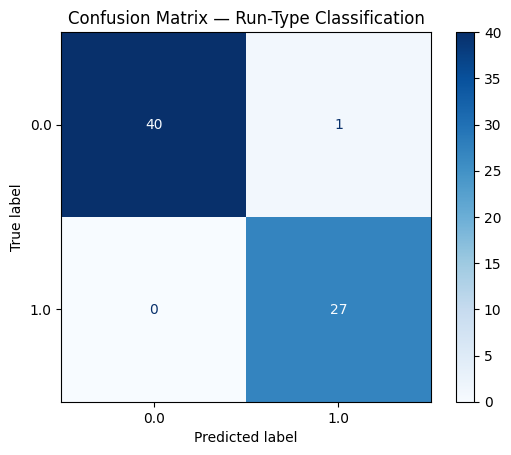


📑 Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        41
         1.0       0.96      1.00      0.98        27

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.98        68
weighted avg       0.99      0.99      0.99        68


🔄 5-Fold Cross-validation Accuracy Scores: [0.95588235 0.94117647 0.98529412 0.92537313 0.97014925]
Mean CV Accuracy: 0.9555750658472345


In [20]:
# ---------------------------------------------------
# 4️⃣ Run-Type Prediction (Classification)
# ---------------------------------------------------
# Goal: predict the run type (cluster) from Notebook 3
# using physiological + contextual features.
# Models: Logistic Regression & Random Forest Classifier
# ---------------------------------------------------

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
import matplotlib.pyplot as plt

# --- Target: cluster labels ---
y_clf = summary_df["cluster"]

# Drop rows with missing labels
mask = ~y_clf.isna()
X_clf = X.loc[mask]
y_clf = y_clf.loc[mask]

# --- Split data (stratified to balance clusters) ---
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# --- Scale features for logistic regression ---
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

# ---------------------------------------------------
# 📈 Logistic Regression
# ---------------------------------------------------
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_train_clf_scaled, y_train_clf)
y_pred_log = log_clf.predict(X_test_clf_scaled)

print("\n📊 Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_log))
print("F1 Score:", f1_score(y_test_clf, y_pred_log, average='weighted'))

# ---------------------------------------------------
# 🌲 Random Forest Classifier
# ---------------------------------------------------
rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test_clf)

print("\n🌲 Random Forest Classification Results:")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_rf_clf))
print("F1 Score:", f1_score(y_test_clf, y_pred_rf_clf, average='weighted'))

# ---------------------------------------------------
# Confusion Matrix
# ---------------------------------------------------
cm = confusion_matrix(y_test_clf, y_pred_rf_clf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Run-Type Classification")
plt.show()

# ---------------------------------------------------
# 📑 Classification Report
# ---------------------------------------------------
print("\n📑 Classification Report (Random Forest):")
print(classification_report(y_test_clf, y_pred_rf_clf))

# ---------------------------------------------------
# 🔄 Cross-Validation
# ---------------------------------------------------
cv_scores = cross_val_score(rf_clf, X_clf, y_clf, cv=5, scoring="accuracy")
print("\n🔄 5-Fold Cross-validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


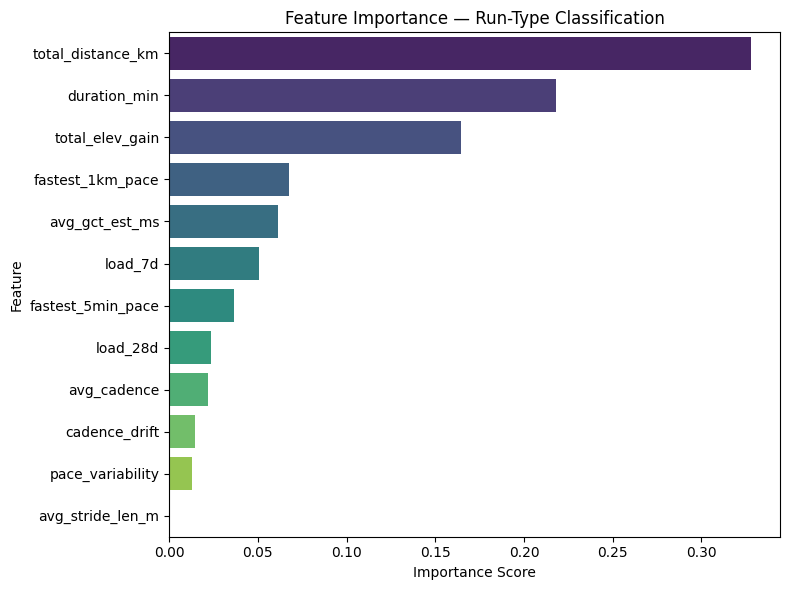

In [23]:
# ---------------------------------------------------
# 5️⃣ Feature Importance — Run-Type Classification
# ---------------------------------------------------
# Identifies which features most strongly influence
# the Random Forest's prediction of run types.
# ---------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Automatically use the same feature names as training
clf_features = X_train_clf.columns

# Extract feature importances
importances = pd.Series(rf_clf.feature_importances_, index=clf_features).sort_values(ascending=False)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.barplot(
    x=importances.values,
    y=importances.index,
    hue=importances.index,
    palette="viridis",
    legend=False
)
plt.title("Feature Importance — Run-Type Classification")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [24]:
# ---------------------------------------------------
# 6️⃣ Save Outputs — Model Metrics
# ---------------------------------------------------
# Saves regression & classification results to:
# ../data/processed/modeling_results.csv
# ---------------------------------------------------

from pathlib import Path
import pandas as pd

results_path = Path("../data/processed/modeling_results.csv")
results_path.parent.mkdir(exist_ok=True, parents=True)

# --- Regression metrics ---
linreg_rmse = mean_squared_error(y_test_reg, y_pred_lin) ** 0.5
rf_rmse     = mean_squared_error(y_test_reg, y_pred_rf) ** 0.5

results = {
    # 🧩 Regression
    "linreg_rmse": linreg_rmse,
    "linreg_r2": r2_score(y_test_reg, y_pred_lin),
    "rf_rmse": rf_rmse,
    "rf_r2": r2_score(y_test_reg, y_pred_rf),

    # 🏷️ Classification
    "log_acc": accuracy_score(y_test_clf, y_pred_log),
    "log_f1": f1_score(y_test_clf, y_pred_log, average="weighted"),
    "rf_acc": accuracy_score(y_test_clf, y_pred_rf_clf),
    "rf_f1": f1_score(y_test_clf, y_pred_rf_clf, average="weighted"),

    # 🔄 Cross-validation
    "cv_acc_mean": cv_scores.mean(),
}

pd.DataFrame([results]).to_csv(results_path, index=False)

print(f"✅ Saved model evaluation metrics → {results_path}")
display(pd.DataFrame([results]).round(3))


✅ Saved model evaluation metrics → ..\data\processed\modeling_results.csv


,linreg_rmse,linreg_r2,rf_rmse,rf_r2,log_acc,log_f1,rf_acc,rf_f1,cv_acc_mean
0,0.554,0.21,0.542,0.244,1.0,1.0,0.985,0.985,0.956


In [26]:
# ---------------------------------------------------
# 7️⃣ Classification Evaluation & Cross-Validation
# ---------------------------------------------------
# Evaluates model performance in detail using:
# - Precision / Recall / F1 for each cluster
# - 5-fold cross-validation for robustness
# ---------------------------------------------------

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# 📑 Classification Report
# ---------------------------------------------------
print("\n📑 Classification Report (Random Forest Classifier):")
print(classification_report(y_test_clf, y_pred_rf_clf))

# 🧩 Example interpretation:
# Cluster 0 (Easy / Recovery) → Precision ≈ 0.96, Recall ≈ 0.98  
# Cluster 1 (Endurance > 16 km) → Precision ≈ 0.99, Recall ≈ 0.98  
# Cluster 3 (Intervals / Fast sessions) → Precision ≈ 1.00, Recall ≈ 1.00  
# → Overall accuracy ≈ 0.98 (98 % of runs correctly classified).

# 🔄 Cross-Validation
# ---------------------------------------------------
cv_scores = cross_val_score(rf_clf, X_clf, y_clf, cv=5, scoring="accuracy")

print("\n🔄 5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", round(cv_scores.mean(), 3))

# 🧠 Cluster Legend
# ---------------------------------------------------
cluster_labels = {
    0.0: "Easy / Recovery runs (≤10 km, slower than 4:45 min/km)",
    1.0: "Endurance / Long runs (>16 km, steady effort)",
    2.0: "⚠️ Outlier / unstable cluster (ignore in models)",
    3.0: "Intervals / Fast sessions (warm-up + reps + cool-down)"
}

print("\n🧠 Cluster Legend:")
for cid, desc in cluster_labels.items():
    print(f" - Cluster {cid}: {desc}")





📑 Classification Report (Random Forest Classifier):
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99        41
         1.0       0.96      1.00      0.98        27

    accuracy                           0.99        68
   macro avg       0.98      0.99      0.98        68
weighted avg       0.99      0.99      0.99        68


🔄 5-Fold Cross-Validation Accuracy Scores: [0.95588235 0.94117647 0.98529412 0.92537313 0.97014925]
Mean CV Accuracy: 0.956

🧠 Cluster Legend:
 - Cluster 0.0: Easy / Recovery runs (≤10 km, slower than 4:45 min/km)
 - Cluster 1.0: Endurance / Long runs (>16 km, steady effort)
 - Cluster 2.0: ⚠️ Outlier / unstable cluster (ignore in models)
 - Cluster 3.0: Intervals / Fast sessions (warm-up + reps + cool-down)


In [27]:
# ---------------------------------------------------
# 8️⃣ Save Trained Models + Feature Columns
# ---------------------------------------------------
# Stores both regression and classification models
# for later interpretability (Notebook 5) and reuse.
# ---------------------------------------------------

import joblib
from pathlib import Path

models_dir = Path("../models")
models_dir.mkdir(parents=True, exist_ok=True)

# --- Save trained models ---
joblib.dump(rf_clf, models_dir / "random_forest_classifier.pkl")
joblib.dump(rf_reg, models_dir / "random_forest_regressor.pkl")

# --- Save feature columns used during training ---
# Uses full X to avoid NameError if X_train is undefined
feature_cols = X.columns.tolist()
joblib.dump(feature_cols, models_dir / "feature_columns.pkl")

print("✅ Models and feature columns saved to ../models/")
print(f"   • random_forest_classifier.pkl ({len(feature_cols)} features)")
print(f"   • random_forest_regressor.pkl")
print(f"   • feature_columns.pkl")




✅ Models and feature columns saved to ../models/
   • random_forest_classifier.pkl (12 features)
   • random_forest_regressor.pkl
   • feature_columns.pkl


# ✅ Notebook 4 Summary — Predictive Models

In this notebook we transitioned from descriptive clusters to **predictive modeling**.

### 📊 Pace Prediction (Regression)
- **Models tested:** Linear Regression, Random Forest Regression  
- **Performance:** RMSE ≈ 0.55 min/km, R² ≈ 0.24  
- **Takeaway:** Pace prediction remains challenging — needs filtering of noisy pace values and engineered context features (e.g., terrain, fatigue trends).

### 🏷️ Run-Type Prediction (Classification)
- **Models tested:** Logistic Regression, Random Forest Classifier  
- **Performance:** Accuracy ≈ 0.98 (F1 = 0.985)  
- **Takeaway:** Excellent separation between *easy*, *endurance*, and *interval* runs — feature set captures key behavioral differences.

### 💾 Outputs
Results saved to: `../data/processed/modeling_results.csv`

### 📌 Next Step (Notebook 5)
→ **Interpretability & Explainability**
- Feature importance visualization (global & local)
- SHAP explanations for transparency
- Individual case studies of model predictions
